In [1]:
import os
import sys
import librosa
import tflearn
import pydub
import wave
import pickle
import speech_data
import segment_data
import tensorflow as tf
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
%matplotlib inline

#cur = os.getcwd()
#os.chdir('/home/cc/')
#import pyAudioAnalysis
#os.chdir(cur)

hdf5 not supported (please install/reinstall h5py)


In [2]:
# load constants - training directory, testing directory
training_data = '/home/cc/Data/Dev-Clean-Full/'
training = '/home/cc/Data/Dev-Clean-Train-Two/'
testing = '/home/cc/Data/Dev-Clean-Test-Two/'

In [3]:
# load one wav file to analyze, play it back
wav_file = os.listdir(training_data)[0]
y, sr = librosa.load(training_data + wav_file)
IPython.display.Audio(data=y, rate=sr)

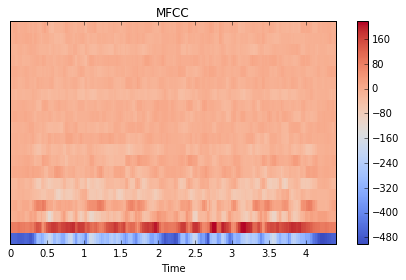

In [4]:
# perform mfcc calculation, display the result in graphic form
mfcc = librosa.feature.mfcc(y=y, sr=sr)
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

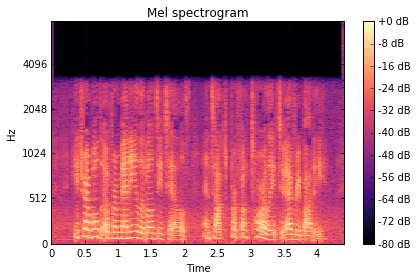

In [5]:
# additionally, display the mel-spectrogram of the audio file
m_spect = librosa.feature.melspectrogram(y=y, sr=sr)
D = librosa.stft(y)
S, phase = librosa.magphase(D)
components, activations = librosa.decompose.decompose(S, n_components=8, sort=True)
librosa.display.specshow(librosa.logamplitude(S, ref_power=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [6]:

# load the mfcc matrices via pickle:
X = pickle.load(open('/home/cc/Data/pickle_files/devfull_delta128_2secX.p', 'rb'))
Y = pickle.load(open('/home/cc/Data/pickle_files/devfull_delta128_2secY.p', 'rb'))
speakers = speech_data.get_speakers(training)


number of files: 5543
(40, ' speakers: ', ['Speaker36', 'Speaker28', 'Speaker29', 'Speaker20', 'Speaker21', 'Speaker22', 'Speaker23', 'Speaker24', 'Speaker25', 'Speaker26', 'Speaker27', 'Speaker1', 'Speaker0', 'Speaker3', 'Speaker2', 'Speaker5', 'Speaker4', 'Speaker7', 'Speaker6', 'Speaker9', 'Speaker8', 'Speaker13', 'Speaker34', 'Speaker11', 'Speaker15', 'Speaker14', 'Speaker37', 'Speaker10', 'Speaker35', 'Speaker12', 'Speaker33', 'Speaker32', 'Speaker31', 'Speaker30', 'Speaker19', 'Speaker18', 'Speaker16', 'Speaker39', 'Speaker38', 'Speaker17'])


In [7]:
'''
Now that this is calculated, do not need to run. Save for later use.

For now using to re-do the training-set and then testing set.

# calculate the mfcc matrices for training from the segmented data
hop_length = 128
X = []
Y = []
speakers = speech_data.get_speakers(training)
for f in os.listdir(training):
    Y.append(speech_data.one_hot_from_item(speech_data.speaker(f), speakers))
    y, sr = librosa.load(training + f)
    #X.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    X.append(np.c_[mfcc,delta,delta2])
pickle.dump(X, open('/home/cc/Data/pickle_files/devfull_delta128_2secX.p', 'wb'))
pickle.dump(Y, open('/home/cc/Data/pickle_files/devfull_delta128_2secY.p', 'wb'))
'''

"\nNow that this is calculated, do not need to run. Save for later use.\n\nFor now using to re-do the training-set and then testing set.\n\n# calculate the mfcc matrices for training from the segmented data\nhop_length = 128\nX = []\nY = []\nspeakers = speech_data.get_speakers(training)\nfor f in os.listdir(training):\n    Y.append(speech_data.one_hot_from_item(speech_data.speaker(f), speakers))\n    y, sr = librosa.load(training + f)\n    #X.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))\n    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length)\n    delta = librosa.feature.delta(mfcc)\n    delta2 = librosa.feature.delta(mfcc, order=2)\n    X.append(np.c_[mfcc,delta,delta2])\npickle.dump(X, open('/home/cc/Data/pickle_files/devfull_delta128_2secX.p', 'wb'))\npickle.dump(Y, open('/home/cc/Data/pickle_files/devfull_delta128_2secY.p', 'wb'))\n"

In [8]:
# define the network and the model for training
layer_size = 160
dropout = 0.7

tflearn.init_graph(num_cores=32, gpu_memory_fraction=0.5)

net = tflearn.input_data(shape=[None, 20, 1035])
net = tflearn.fully_connected(net, layer_size, activation='relu')
net = tflearn.fully_connected(net, layer_size, activation='relu')
net = tflearn.fully_connected(net, layer_size, activation='relu')
#net = tflearn.fully_connected(net, layer_size, activation='relu')
#net = tflearn.fully_connected(net, layer_size, activation='relu')
#net = tflearn.fully_connected(net, layer_size, activation='relu')
net = tflearn.dropout(net, dropout)
net = tflearn.fully_connected(net, len(speakers), activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.001)

In [9]:
# now train the model!
run_id = 'delta128_40_1'
model = tflearn.DNN(net)
model.fit(X, Y, n_epoch=75, show_metric=True, snapshot_step=1000, run_id=run_id, validation_set=0.1)

Training Step: 5850  | total loss: 0.07092
| Adam | epoch: 075 | loss: 0.07092 - acc: 0.9899 | val_loss: 1.00268 - val_acc: 0.9279 -- iter: 4988/4988
Training Step: 5850  | total loss: 0.07092
| Adam | epoch: 075 | loss: 0.07092 - acc: 0.9899 | val_loss: 1.00268 - val_acc: 0.9279 -- iter: 4988/4988
--


In [10]:
# now test the model using the testing directory
#testX = pickle.load(open('/home/cc/Data/pickle_files/devfull_delta_2sectestX.p', 'rb'))
#testY = pickle.load(open('/home/cc/Data/pickle_files/devfull_2sectestY.p', 'rb'))

hop_length = 128
testX = []
for f in os.listdir(testing):
    y, sr = librosa.load(testing + f)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    testX.append(np.c_[mfcc,delta,delta2])
pickle.dump(testX, open('/home/cc/Data/pickle_files/devfull_delta128_2sectestX.p', 'wb'))

result = model.predict(testX)
c = 0
for f,r in zip(os.listdir(testing), result):
    res = speech_data.one_hot_to_item(r, speakers)
    if res in f:
      #print('Actual: ' + f[:9] + '; Chosen: ' + res)
      c = c + 1
    #else:
      #print(c)
#print(len(testY))
acc = float(c) / float(len(testX))
print('Test set accuracy: %s' %str(acc))

Test set accuracy: 0.927128427128


In [11]:
# append results to text file
# need to include: layer size, dropout size, train / test results
l = ['ID: ' + run_id + ' Layer Size : ' + str(layer_size), 'Dropout: ' + str(dropout), 'Test: ' + str(acc)]

with open('libri_layer_stats.txt', 'a') as myfile:
    [myfile.write(a + ' , ') for a in l]
    myfile.write('\n')

In [12]:
#model.save('devfull.model')
#_y = model.predict(testX)